## Imports

In [58]:
import utils
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch_geometric as pyg
from torch_geometric.utils import negative_sampling

from sklearn.preprocessing import LabelEncoder

# Data Loading

## Dataset

In [10]:
data_h5 = utils.read_h5("frames_data_small.h5")
metavd_path = 'metavd_v1.csv'

## Graph Loader Class

In [32]:
class GraphLoader:
    def __init__(self, verbose=False, visualization=False) -> None:
        #each key is a label and each value is the label's id and also an array of the video ids
        self.labels = {}
        #never used but is a set of all used node_ids
        self.all_node_ids = set()
        #next id that will get assigned
        self.cur_id = 0
        #actual graph
        self.G = nx.Graph()
        #verbose printing
        self.verbose = verbose

        self.visualization = visualization

    #give nodes an id for graph connections
    def get_id(self):
        self.all_node_ids.add(self.cur_id)
        r = self.cur_id
        self.cur_id+=1
        if self.cur_id % 1000:
            if self.verbose:
                print("loaded id", self.cur_id)
        return r

    #iterate all in h5 and create nodes and store set of all nodes of each type
    def create_labels(self, data_h5):
        counter_3840 = 0
        counter_3072 = 0
        other_counter = 0
        for key in data_h5.keys():
            l = data_h5[key]['label'].decode('utf-8')
            dataset = data_h5[key]['dataset'].decode('utf-8')
            unique_label = f'{l}-{dataset}'
            #unique_label = l

            id = self.get_id()
            if unique_label in self.labels:
                self.labels[unique_label]['nodes'].append(id)
            else:
                self.labels[unique_label] = {}
                self.labels[unique_label]['nodes'] = [id]
                label_id = self.get_id()
                self.labels[unique_label]['label_id'] = label_id
                self.labels[unique_label]['dataset'] = dataset
                self.G.add_node(
                    label_id,
                    node_type='label',
                    label=unique_label
                )

            """
            print()
            for attribute in data_h5[key]:
                print(attribute)
                print(type(data_h5[key][attribute]))
            print()
            """
            
            if not self.visualization:
              if data_h5[key]['embeddings'].shape == torch.Size([3840]):
                  self.G.add_node(
                  id,
                  node_type='video',
                  dataset=data_h5[key]['dataset'].decode('utf-8'),
                  label=data_h5[key]['label'].decode('utf-8'),
                  split=data_h5[key]['split'].decode('utf-8'),
                  num_frames=int(data_h5[key]['num_frames']),
                  frame_indices=data_h5[key]['frame_indices'].tolist(),
                  frames=data_h5[key]['frames'].tolist(),
                  raw_path=data_h5[key]['raw_path'].decode('utf-8'),
                  embeddings=data_h5[key]['embeddings'].tolist()
              )
            else:
              self.G.add_node(
                  id,
                  node_type='video',
                  dataset=data_h5[key]['dataset'].decode('utf-8'),
                  label=data_h5[key]['label'].decode('utf-8')
              )
              
            """
            self.G.add_node(
                id,
                node_type='video',
                dataset=data_h5[key]['dataset'].decode('utf-8'),
                label=data_h5[key]['label'].decode('utf-8'),
                split=data_h5[key]['split'].decode('utf-8'),
                num_frames=int(data_h5[key]['num_frames']),
                frame_indices=data_h5[key]['frame_indices'].tolist(),
                frames=data_h5[key]['frames'].tolist(),
                raw_path=data_h5[key]['raw_path'].decode('utf-8'),
                embeddings=data_h5[key]['embeddings'].tolist()
            )
            """
        print("3072", counter_3072)
        print("3840", counter_3840)
        print('other', other_counter)

    #iterate all sets of types of nodes and create node and interconnect all nodes within the set
    def connect_videos(self):
        for unique_label in self.labels:
            for node_id in self.labels[unique_label]['nodes']:
                self.G.add_edge(self.labels[unique_label]['label_id'], node_id, relationship='video-to-label')
                for other_id in self.labels[unique_label]['nodes']:
                    if node_id != other_id:
                        self.G.add_edge(other_id, node_id, relationship='video-to-video')

    #iterate all csv connections and create virtual node connections
    def connect_labels(self, csv_path, include_is_a=True):
        #df_edges = pd.read_csv(csv_path, usecols=['from_action_name', 'to_action_name', 'relation'])
        df_edges = pd.read_csv(csv_path)
        for _, edge_data in tqdm.tqdm(df_edges.iterrows()):
            relation = edge_data['relation']

            #is_a_labels = related_labels(metavd_df, true_label, dataset, 'is-a')
            #similar_labels = related_labels(metavd_df, true_label, dataset, 'similar')
            #equal_labels = related_labels(metavd_df, true_label, dataset, 'equal')

            if relation != 'is-a' or include_is_a:
                action_name_1 = f'{edge_data["from_action_name"]}-{edge_data["from_dataset"]}'
                action_name_2 = f'{edge_data["to_action_name"]}-{edge_data["to_dataset"]}'
                #action_name_1 = f'{edge_data["from_action_name"]}'
                #action_name_2 = f'{edge_data["to_action_name"]}'
                if action_name_1 in self.labels and action_name_2 in self.labels:
                    from_id = self.labels[action_name_1]['label_id']
                    to_id = self.labels[action_name_2]['label_id']
                    self.G.add_edge(from_id, to_id, relationship='label-to-label-'+relation)
                else:
                    if self.verbose:
                        if action_name_1 not in self.labels:
                            print(f'{action_name_1} not in self.labels')
                        if action_name_2 not in self.labels:
                            print(f'{action_name_2} not in self.labels')

    def create_graph(self, data_h5, csv, export_path, export=False):
        self.create_labels(data_h5)
        self.connect_videos()
        self.connect_labels(csv, include_is_a=True)
        if export:
            self.export_graph(export_path)

    #draw the graph
    def draw_graph(self):
        nx.draw(self.G, with_labels=True, font_weight='bold', node_size=300, node_color='skyblue', font_color='black', font_size=8)
        plt.show()

    def export_graph(self, export_path):
        G_export = nx.Graph()
        for node, attrs in self.G.nodes(data=True):
            converted_attrs = {key: str(value) for key, value in attrs.items()}
            G_export.add_node(node, **converted_attrs)

         # Export the new graph to GEXF
        nx.write_graphml(G_export, export_path)

## Graph Initialization

In [33]:
gl = GraphLoader(verbose=True, visualization=False)
gl.create_graph(data_h5=data_h5, csv=metavd_path, export_path='metavd_v1.graphml')

loaded id 1
loaded id 2
loaded id 3
loaded id 4
loaded id 5
loaded id 6
loaded id 7
loaded id 8
loaded id 9
loaded id 10
loaded id 11
loaded id 12
loaded id 13
loaded id 14
loaded id 15
loaded id 16
loaded id 17
loaded id 18
loaded id 19
loaded id 20
loaded id 21
loaded id 22
loaded id 23
loaded id 24
loaded id 25
loaded id 26
loaded id 27
loaded id 28
loaded id 29
loaded id 30
loaded id 31
loaded id 32
loaded id 33
loaded id 34
loaded id 35
loaded id 36
loaded id 37
loaded id 38
loaded id 39
loaded id 40
loaded id 41
loaded id 42
loaded id 43
loaded id 44
loaded id 45
loaded id 46
loaded id 47
loaded id 48
loaded id 49
loaded id 50
loaded id 51
loaded id 52
loaded id 53
loaded id 54
loaded id 55
loaded id 56
loaded id 57
loaded id 58
loaded id 59
loaded id 60
loaded id 61
loaded id 62
loaded id 63
loaded id 64
loaded id 65
loaded id 66
loaded id 67
loaded id 68
loaded id 69
loaded id 70
loaded id 71
loaded id 72
loaded id 73
loaded id 74
loaded id 75
loaded id 76
loaded id 77
loaded i

2801it [00:00, 54151.86it/s]

catch-hmdb51 not in self.labels
Reaching for and grabbing a picture-charades not in self.labels
Eating a sandwich-charades not in self.labels
Someone is eating something-charades not in self.labels
drink-hmdb51 not in self.labels
Drinking from a cup/glass/bottle-charades not in self.labels
drink-hmdb51 not in self.labels
Taking/consuming some medicine-charades not in self.labels
Eating a sandwich-charades not in self.labels
Someone is eating something-charades not in self.labels
laugh-hmdb51 not in self.labels
Smiling at a book-charades not in self.labels
laugh-hmdb51 not in self.labels
Laughing at a picture-charades not in self.labels
laugh-hmdb51 not in self.labels
Smiling in a mirror-charades not in self.labels
laugh-hmdb51 not in self.labels
Laughing at television-charades not in self.labels
laugh-hmdb51 not in self.labels
Someone is laughing-charades not in self.labels
laugh-hmdb51 not in self.labels
Someone is smiling-charades not in self.labels
Holding some clothes-charades not 

## Data Visualize

In [13]:
import random

def plot_graph(gl, add_video=False, sampled_videos=5):
  print("Plotting label graph")
  node_ids = [info['label_id'] for label, info in gl.labels.items()]
  color_map = {"hmdb51": "blue", "ucf101": "red", "kinetics700": "green"}
  label_colors = [color_map[info['dataset']] for label, info in gl.labels.items()]

  # add video nodes for each label
  if add_video:
    for label, info in gl.labels.items():
      node_ids += random.sample(info['nodes'], sampled_videos)
      label_colors += sampled_videos * [color_map[info['dataset']]]

  label_graph = gl.G.subgraph(node_ids)
  pos = nx.spring_layout(label_graph)
  plt.figure(figsize=(10, 10))
  nx.draw(label_graph, pos=pos, node_color=label_colors, cmap=plt.get_cmap('coolwarm'), node_size=5)
  plt.show()

Plotting label graph


/Users/benokeefe/Documents/CS224WProject/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


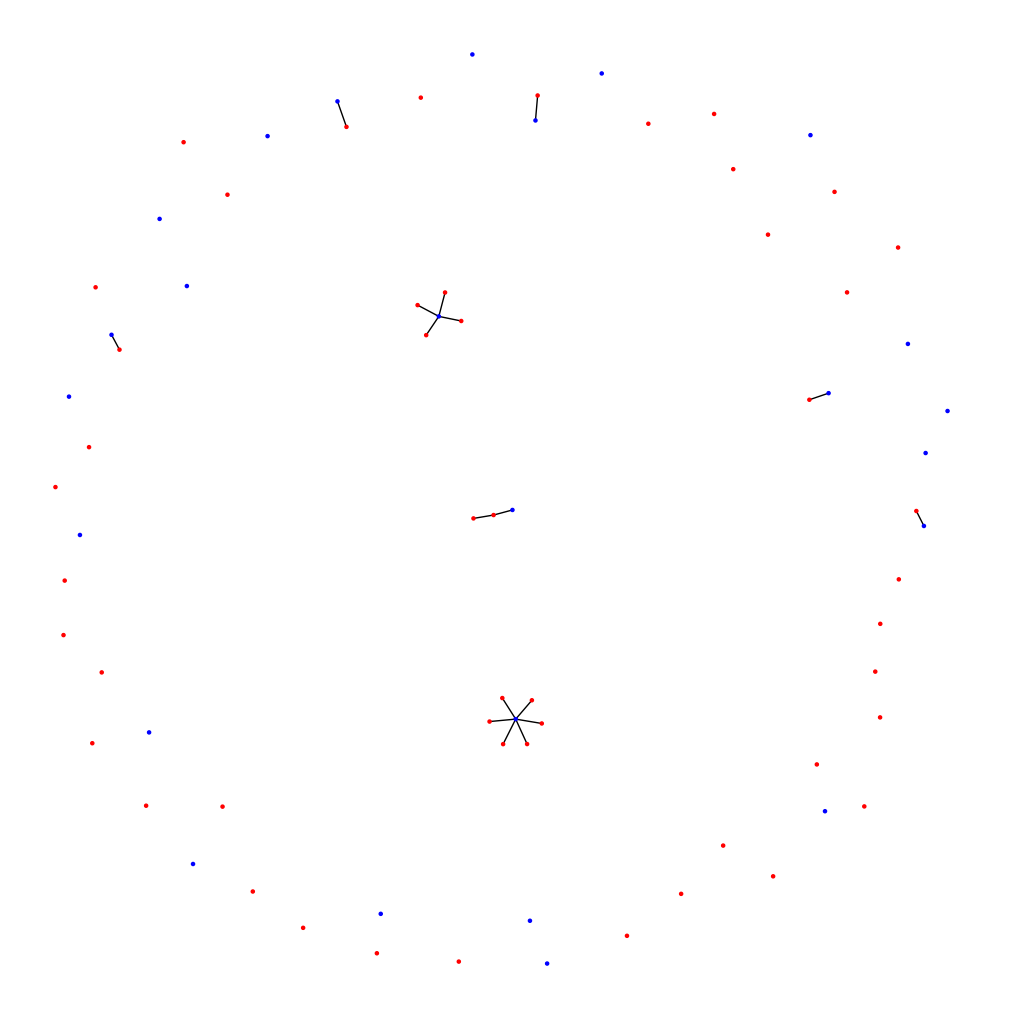

In [14]:
plot_graph(gl, False)

In [34]:
# stats
print(f'Number of nodes: {gl.G.number_of_nodes()}')
print(f'Number of edges: {gl.G.number_of_edges()}')
print(f'Number of labels: {len(gl.labels)}')
print(f'Average amount of nodes per label: {gl.G.number_of_nodes()/len(gl.labels)}')

print(f'Number of label-to-label similar relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-similar"])}')
print(f'Number of label-to-label is-a relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-is-a"])}')
print(f'Number of label-to-label equal relations: {len([x for x in nx.get_edge_attributes(gl.G, "relationship").values() if x == "label-to-label-equal"])}')

Number of nodes: 185
Number of edges: 162
Number of labels: 75
Average amount of nodes per label: 2.466666666666667
Number of label-to-label similar relations: 2
Number of label-to-label is-a relations: 13
Number of label-to-label equal relations: 2


## Data Converter

In [46]:
graph = gl.G

# (3840,)

random_feature_size = 3840  # Adjust this based on the desired size of the random feature array
node_features = torch.tensor(
    [graph.nodes[node].get('embeddings', np.random.rand(random_feature_size).astype(np.float32)) for node in graph.nodes()],
    dtype=torch.float32
)
for node in graph.nodes():
    if 'label' not in graph.nodes[node]:
        print('node', graph.nodes[node])

node_labels = [graph.nodes[node].get('label', 'NONE') for node in graph.nodes()]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(node_labels)
node_labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

# Extract edge information
edge_index = torch.tensor(list(graph.edges)).t().contiguous()

# Create a PyG Data object
pyg_data = Data(x=node_features, y=node_labels_tensor, edge_index=edge_index)


node {}
node {}
node {}


## PyG Graph Stats

In [59]:

# Print node features
print("Node Features:")
print(pyg_data.x)

# Print node labels
print("\nNode Labels:")
print(pyg_data.y)

# Print edge index
print("\nEdge Index:")
print(pyg_data.edge_index)

# Print the number of nodes
print("\nNumber of Nodes:", pyg_data.num_nodes)

# Print the number of edges
print("Number of Edges:", pyg_data.num_edges)

# Print the number of node features
print("Number of Node Features:", pyg_data.num_node_features)

# Print whether


Node Features:
tensor([[ 0.8182,  0.5277,  0.5529,  ...,  0.9549,  0.7134,  0.5786],
        [ 0.5458,  0.9163,  0.8194,  ...,  0.2830,  0.9171,  0.2226],
        [-0.1415,  0.5428,  0.3027,  ..., -1.2169,  1.4621,  0.1875],
        ...,
        [ 0.8807,  0.2826,  0.3542,  ...,  0.0803,  0.7624,  0.8810],
        [ 0.5782,  0.5669,  0.6175,  ...,  0.8958,  0.1531,  0.1871],
        [ 0.3693,  0.3552,  0.2989,  ...,  0.6623,  0.6468,  0.0552]])
torch.Size([185, 3840])

Node Labels:
tensor([129, 141, 140, 120, 119, 108, 107, 106, 105, 124, 123, 126, 139, 138,
        122, 121, 137, 136, 147, 146, 133, 132, 116, 115, 143, 142, 125, 145,
        144, 114, 113, 131, 130, 118, 117, 110, 109, 112, 111, 135, 134, 104,
        103, 128, 127, 102, 101,   1,   0,   3,   2,   2,   5,   4,   4,   9,
          8,   8,   7,   6,   6,  11,  10,  10,  13,  12,  12,  15,  14,  17,
         16,  16,  19,  18,  18,  21,  20,  23,  22,  25,  24,  24,  27,  26,
         26,  29,  28,  31,  30,  30,  33,  3

## Construct Positive and Negative Edges

In [64]:
def graph_to_edge_list(G):
  edge_list = []
  edge_list = list(G.edges)
  return edge_list

def edge_list_to_tensor(edge_list):
  edge_index = torch.LongTensor([])
  edge_index = torch.LongTensor(edge_list)
  edge_index = torch.t(edge_index)
  return edge_index

pos_edge_list = graph_to_edge_list(graph)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 162])
The pos_edge_index tensor has sum value 31459


In [52]:
def get_negative_edges(G):
  negative_edges = []
  all_edges = [[u, v] for u in G.nodes() for v in G.nodes() if u < v]
  for edge in list(G.edges):
    all_edges.remove(sorted(edge))
  negative_edges = all_edges
  return negative_edges

def sample_negative_edges(G, num_neg_samples):
  neg_edge_list = []

  negative_edges = get_negative_edges(G)
  for _ in range(num_neg_samples):
    neg_edge = random.choice(negative_edges)
    neg_edge_list.append(neg_edge)
    negative_edges.remove(neg_edge)

  return neg_edge_list

neg_edge_list = sample_negative_edges(graph, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))
print("neg_edge_index", neg_edge_index)


The neg_edge_index tensor has shape torch.Size([2, 162])
neg_edge_index tensor([[ 11,  96, 125,  65,  19,  94, 100, 105,  79,  19,  35,  44,  49,  17,
         110, 104,  68,   5,  40,  84,  71,  22, 105, 133,  97,  89,  15, 148,
          55,  87,   0,  90,  11,  38,  57,  69,  19,  25,  81,  97,  52,  79,
          40, 109,  92,  74,  78,  65,  13,  14,   8,  28,  31,  14, 118,   3,
          40, 127,  43,  47,  99, 161,  16,  45,  27,  90,  22,  94,  34, 108,
          16,  55,  53,  69,  82, 130,  52,  30, 130,  68, 158,  30, 152, 120,
          14,  10, 105,  68, 111, 145, 121,   1, 148,  58,  17,  18,  15, 106,
          89,   4,   1, 128,  46,  53,  61,  14,  64,  17, 162, 126,  41, 129,
           3,  17,  71,  15,  97,  81,  99, 121,  59,   7,  68,  66,  55, 142,
          31,  24,   3,  45,  36, 129,  27, 133,  74,  72,  77, 139,  83,  70,
          10,  58,  12,  29,  54, 132,  71,  87,  11,  20, 105, 117,  79,  54,
          67,  67,  53,  28,  47,  46,  53,  39],
        [

# GNN Model

## GNN Model

In [56]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = pyg.nn.SAGEConv

        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        self.dropout = dropout
        self.num_layers = num_layers
        self.emb = emb

        # Create num_layers GraphSAGE convs
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing processing 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of embeddings if specified
        if self.emb:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

## Link Prediction Model

In [ ]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

## Train Function

In [ ]:
def train(model, link_predictor, emb, edge_index, pos_train_edge, batch_size, optimizer):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param pos_train_edge: (PE, 2) Positive edges used for training supervision loss
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    model.train()
    link_predictor.train()

    train_losses = []

    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        # Run message passing on the inital node embeddings to get updated embeddings
        node_emb = model(emb, edge_index)  # (N, d)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T  # (2, B)
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(edge_index, num_nodes=emb.shape[0],
                                     num_neg_samples=edge_id.shape[0], method='dense')  # (Ne,2)
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])  # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

## Test Function

In [ ]:
def test(model, predictor, emb, edge_index, split_edge, batch_size, evaluator):
    """
    Evaluates graph model on validation and test edges
    :param model: Torch Graph model used for updating node embeddings based on message passing
    :param predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph
    :param split_edge: Dictionary of (e, 2) edges for val pos/neg and test pos/neg edges
    :param batch_size: Number of positive (and negative) supervision edges to sample per batch
    :param evaluator: OGB evaluator to calculate hits @ k metric
    :return: hits @ k results
    """
    model.eval()
    predictor.eval()

    node_emb = model(emb, edge_index)

    pos_valid_edge = split_edge['valid']['edge'].to(emb.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(emb.device)
    pos_test_edge = split_edge['test']['edge'].to(emb.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(emb.device)
    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    # for K in [20, 50, 100]:
    #     evaluator.K = K
    #     valid_hits = evaluator.eval({
    #         'y_pred_pos': pos_valid_pred,
    #         'y_pred_neg': neg_valid_pred,
    #     })[f'hits@{K}']
    #     test_hits = evaluator.eval({
    #         'y_pred_pos': pos_test_pred,
    #         'y_pred_neg': neg_test_pred,
    #     })[f'hits@{K}']

    #     results[f'Hits@{K}'] = (valid_hits, test_hits)

    return results

## Calling Training

Hyperparameter

In [62]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 300
node_emb_dim = 3840
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 3e-3
batch_size = 64 * 1024

Construct Edge Split

In [ ]:
def construct_edge_splits(graph, num_train, num_valid, num_test):
    pos_edge_list = graph_to_edge_list(graph)
    pos_edge_index = edge_list_to_tensor(pos_edge_list)
    
    e = pos_edge_index.T
    if num_train + num_valid + num_test > len(e):
        raise ValueError('Num Training, Valid, and Test more than positive edges')
    split_edge  = {'train': {}, 'valid': {}, 'test': {}}
    split_edge['train']['edge'] = e[0:num_train].T
    split_edge['valid']['edge'] = e[num_train:num_train+num_valid].T
    split_edge['valid']['edge_neg'] = edge_list_to_tensor(sample_negative_edges(graph, num_valid))
    split_edge['test']['edge'] = e[num_train+num_valid:].T
    split_edge['test']['edge_neg'] = edge_list_to_tensor(sample_negative_edges(graph, num_test))
    return split_edge

num_train = 50
num_valid = 50
num_test = 50

split_edge = construct_edge_splits(graph, num_train, num_valid, num_test)

Train Model

In [ ]:
pos_train_edge = split_edge['train']['edge'].to(device)

edge_index = pos_edge_index

evaluator = Evaluator(name='ogbl-ddi')

emb = nn.Embedding.from_pretrained(pyg_data.x, freeze=False).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)

train_loss = []
val_hits = []
test_hits = []
for e in range(epochs):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    train_loss.append(loss)

    if (e+1)%10 ==0:
        result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
        val_hits.append(result['Hits@20'][0])
        test_hits.append(result['Hits@20'][1])
        print(result)

plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
plt.plot(np.arange(9,epochs,10),val_hits,label="Hits@20 on validation")
plt.plot(np.arange(9,epochs,10),test_hits,label="Hits@20 on test")
plt.xlabel('Epochs')
plt.legend()
plt.show()